# **Дипломный проект**
# **Модель прогнозирования стоимости жилья для агентства недвижимости**

Цель работы: разработать модель, которая помогла бы агентству недвижимости более быстро обрабатывать объявления и увеличить количество сделок и доход компании.

Описание данных:

*   status — статус продажи;
*   private pool и PrivatePool — наличие собственного бассейна;
*   propertyType - тип объекта недвижимости;
*   street — адрес объекта;
*   baths — количество ванных комнат;
*   homeFacts — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
*   fireplace — наличие камина;
*   city — город;
*   schools — сведения о школах в районе;
*   sqft — площадь в футах;
*   zipcode — почтовый индекс;
*   beds — количество спален;
*   state — штат;
*   stories — количество этажей;
*   mls-id и MlsId — идентификатор MLS (Multiple Listing Service, система мультилистинга);
*   target — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).




Импортируем необходимые библиотеки.

In [4]:
import pandas as pd
import numpy as np
import sweetviz as sv
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
import pickle

## 1. Знакомство с данными и первичный анализ

In [5]:
data = pd.read_csv('data/data.csv')

In [6]:
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Просмотрим информацию о наборе данных в первоначальном виде и проведём первичный анализ данных при помощи модуля SWEETVIZ.

In [8]:
report = sv.analyze(data)
report.show_html()

c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future ver

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Видим, что набор данных состоит из 377185 строк и 18 признаков.
В данных очень много пропусков - все признаки, кроме 'homeFacts', 'schools', 'zipcode' и 'state', имеют пропуски.
В наборе данных имеются два схожих признака 'privat pool' и 'PrivatPool', которые можно объединить в один признак.


**Признаки 'mls-id' и 'MlsId'**

Так как признаки 'MlsId' и 'mls-id' являются идентификаторами в системе мультилистинга, то на цену объекта они не влияют, эти признаки можно удалить.

In [9]:
data.drop(['mls-id','MlsId'],axis=1, inplace=True)

**Признак 'target'**

In [10]:
data['target'].isna().sum()

2481

В наборе данных имеется 2481 строк без указания цены объекта. Эти строки не представляют ценности для нас, их можно удалить.

In [11]:
data.dropna(subset = ['target'], inplace = True )
data.reset_index(drop = True, inplace = True )

In [12]:
data['target'].nunique()

43939

Уберем лишние символы и приведём признак 'target' к числовому типу. При этом значение '1215-1437' заменим на среднее значение.

In [13]:
data['target'] = data['target'].apply(lambda x: str(x).replace('$', '').replace(',', '').replace(' ', '').replace('+', '').replace('/mo', '').replace('1215-1437', '1326'))

In [14]:
data['target'] = data['target'].astype(float)

In [15]:
data['target'].value_counts()

225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
325000.0    1562
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34232, dtype: int64

**Признаки 'privat pool' и 'PrivatPool'**

Исходя из первичного анализа данных при помощи sweetviz мы знаем, что признак 'privat pool' имеет 4181 ответов Yes и 373004 пропуска, а признак 'PrivatPool' имеет 28793 ответа yes, 11518 ответа Yes и  336874 пропуска.

Сделаем признаки наличия бассеина бинарными.

In [16]:
data['private pool'] = data['private pool'].apply(lambda x: 1 if x=='Yes' else 0)
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)

Объединим признаки 'privat pool' и 'PrivatPool' в общий признак 'pool'.

In [17]:
data['pool'] = data['private pool'] | data['PrivatePool']
data.drop(['private pool'], axis=1, inplace=True)
data.drop(['PrivatePool'], axis=1, inplace=True)

In [18]:
data['pool'].value_counts()

0    330432
1     44272
Name: pool, dtype: int64

**Признак 'zipcode'**

Признак 'zipcode' является почтовым индексом объекта недвижимости и не оказывает влияния на формирование цены, поэтому его можно удалить.

In [19]:
data.drop(['zipcode'],axis=1, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374704 entries, 0 to 374703
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335447 non-null  object 
 1   propertyType  340150 non-null  object 
 2   street        374702 non-null  object 
 3   baths         269328 non-null  object 
 4   homeFacts     374704 non-null  object 
 5   fireplace     102522 non-null  object 
 6   city          374670 non-null  object 
 7   schools       374704 non-null  object 
 8   sqft          334582 non-null  object 
 9   beds          283748 non-null  object 
 10  state         374704 non-null  object 
 11  stories       224910 non-null  object 
 12  target        374704 non-null  float64
 13  pool          374704 non-null  int64  
dtypes: float64(1), int64(1), object(12)
memory usage: 40.0+ MB


Сделаем копию обработанной части датасета.

In [21]:
data1 = data.copy()

**Признак 'baths'**

Посмотрим уникальные значения признака 'baths' в упорядоченном порядке.

In [22]:
data1['baths'].sort_values().unique()

array(['-- baths', '0', '0 / 0', '0.0', '0.00', '0.5 Baths', '0.75 Baths',
       '1', '1 / 1 / 1 / 1', '1 / 1-0 / 1-0 / 1-0', '1 ba', '1,000',
       '1,250', '1,500', '1,750', '1-0 / 1-0 / 1', '1-2 Baths', '1.0',
       '1.1 Baths', '1.25 Baths', '1.5', '1.5 Baths', '1.5 ba', '1.5+',
       '1.75 Baths', '1.75 ba', '10', '10 Baths', '10 ba', '10.0', '10.5',
       '10.5 Baths', '10.5+', '11', '11 Baths', '11 ba', '11.0',
       '11.5 Baths', '11.5+', '116 / 116 / 116', '12', '12 Baths',
       '12 ba', '12.0', '12.5', '12.5+', '13', '13 Baths', '13 ba',
       '13.0', '14', '14 Baths', '14.0', '14.5+', '15', '15 Baths',
       '15.0', '16', '16 Baths', '16 ba', '16.0', '17', '17 Baths',
       '17.0', '18', '18 Baths', '18.0', '19 Baths', '2', '2 Baths',
       '2 ba', '2 baths', '2,000', '2,250', '2,500', '2,750',
       '2-1 / 2-1 / 1-1 / 1-1', '2.0', '2.1 Baths', '2.2 Baths',
       '2.25 Baths', '2.25 ba', '2.5', '2.5 Baths', '2.5 ba', '2.5+',
       '2.75 Baths', '20', '20 Baths

Приведём все значения к нижнему регистру.

In [23]:
data1['baths'] = data1['baths'].apply(lambda x: str(x).lower())

Обработаем признак 'baths' и вновь посмотрим список уникальных значений.

In [24]:
data1['baths'] = data1['baths'].fillna('UNKNOWN')
data1['baths'] = data1['baths'].apply(lambda x: 'UNKNOWN' if (x=='sq. ft. ') | (x=='bathrooms: semimod') | (x=='nan') | (x=='-- baths') | (x=='~') | (x=='—') else x)
data1['baths'] = data1['baths'].apply(lambda x: '0' if (x=='0.00') | (x=='0 / 0') | (x=='0.0') | (x=='-- baths') | (x=='~') | (x=='—') else x)
data1['baths'] = data1['baths'].apply(lambda x: '1.5' if (x=='1-2 baths') else x)

In [25]:
data1['baths'] = data1['baths'].str.replace('[a-z]', '', regex=True)
data1['baths'] = data1['baths'].str.replace(' ', '', regex=True)
data1['baths'] = data1['baths'].str.replace(':', '', regex=True)
data1['baths'] = data1['baths'].str.replace(',', '.', regex=True)
data1['baths'] = data1['baths'].str.replace('\+', '', regex=True)

In [26]:
data1['baths'] = data1['baths'].apply(lambda x: '0.5' if (x=='0.75') else x)
data1['baths'] = data1['baths'].apply(lambda x: '4' if (x=='1/1/1/1') | (x=='1/1-0/1-0/1-0') | (x=='2-1/2-1/1-1/1-1') | (x=='4.0') | (x=='4.1') | (x=='4.25') | (x=='4.000') else x)
data1['baths'] = data1['baths'].apply(lambda x: '4.5' if (x=='4.75') else x)
data1['baths'] = data1['baths'].apply(lambda x: '3' if (x=='1-0/1-0/1') | (x=='116/116/116') | (x=='3.0') | (x=='3.1') | (x=='3.2') | (x=='3.25') | (x=='3.000') else x)
data1['baths'] = data1['baths'].apply(lambda x: '3.5' if (x=='3.500') | (x=='3.75') else x)
data1['baths'] = data1['baths'].apply(lambda x: '2' if (x=='3-1/2-2') | (x=='2.0') | (x=='2.1') | (x=='2.2') | (x=='2.25') | (x=='2.250') | (x=='2.000') else x)
data1['baths'] = data1['baths'].apply(lambda x: '2.5' if (x=='2.500') | (x=='2.75') | (x=='2.750') else x)
data1['baths'] = data1['baths'].apply(lambda x: '1' if (x=='1.0') | (x=='1.1') | (x=='1.25') | (x=='1.250') | (x=='1.000') else x)

In [27]:
data1['baths'] = data1['baths'].apply(lambda x: '11' if (x=='11.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '12' if (x=='12.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '13' if (x=='13.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '14' if (x=='14.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '15' if (x=='15.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '16' if (x=='16.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '17' if (x=='17.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '18' if (x=='18.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '20' if (x=='20.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '22' if (x=='22.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '23' if (x=='23.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '24' if (x=='24.0') | (x=='241') else x)
data1['baths'] = data1['baths'].apply(lambda x: '30' if (x=='30.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '34' if (x=='34.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '41' if (x=='41.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '44' if (x=='44.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '5' if (x=='5.0') | (x=='5.000') | (x=='5.2') | (x=='5.25') else x)
data1['baths'] = data1['baths'].apply(lambda x: '55' if (x=='55.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '6' if (x=='6.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '6.5' if (x=='6.75') else x)
data1['baths'] = data1['baths'].apply(lambda x: '64' if (x=='64.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '7' if (x=='7.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '7.5' if (x=='7.500') | (x=='750') else x)
data1['baths'] = data1['baths'].apply(lambda x: '8' if (x=='8.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '9' if (x=='9.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '10' if (x=='10.0') else x)
data1['baths'] = data1['baths'].apply(lambda x: '1.5' if (x=='1.500') | (x=='1.75') | (x=='1.750') else x)

In [28]:
data1['baths'].sort_values().unique()

array(['0', '0.5', '1', '1.5', '10', '10.5', '11', '11.5', '12', '12.5',
       '13', '14', '14.5', '15', '16', '17', '18', '19', '2', '2.5', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '3.5',
       '30', '32', '34', '35', '36', '39', '4', '4.5', '40', '41', '42',
       '43', '44', '5', '5.5', '55', '6', '6.5', '60', '64', '68', '7',
       '7.5', '76', '8', '8.5', '9', '9.5', 'UNKNOWN'], dtype=object)

Оставим 10 наибольших значений, а остальное заменим на 'other'.

In [29]:
top_baths = data1['baths'].value_counts()[:10].index
data1['baths'] = data1['baths'].apply(lambda x: x
                                            if x in top_baths else 'other')
data1['baths'] = data1['baths'].apply(lambda x: '0' if (x=='UNKNOWN') | (x=='other') else x)

In [30]:
data1['baths'].value_counts()

0      118206
2      104260
3       66449
4       26248
1       18743
2.5     14745
5        9440
3.5      6160
1.5      6160
6        4293
Name: baths, dtype: int64

In [31]:
data1['baths'] = data1['baths'].astype(float)

In [32]:
data1['baths'] = data1['baths'].replace(0, data1['baths'].median(), regex=True)

In [33]:
data1['baths'].value_counts()

2.0    222466
3.0     66449
4.0     26248
1.0     18743
2.5     14745
5.0      9440
3.5      6160
1.5      6160
6.0      4293
Name: baths, dtype: int64

Сохраним полученный датасет под именем data2.

In [34]:
data2 = data1.copy()

**Признак 'fireplace'**

In [35]:
data2['fireplace'].value_counts()

yes                                                                     50018
Yes                                                                     20619
1                                                                       14533
2                                                                        2432
Not Applicable                                                           1990
                                                                        ...  
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
FAMILYRM, Great Room, Living Room                                           1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: fireplace, Length: 1653, dtype: int64

In [36]:
data2['fireplace'].isna().sum()

272182

Заменим все пропуски на 'no'.

In [37]:
data2['fireplace'] = data2['fireplace'].fillna('no')

Приведём все символы к нижнему регистру.

In [38]:
data2['fireplace'] = data2['fireplace'].apply(lambda x: str(x).lower())

In [39]:
data2['fireplace'].unique()[:30]

array(['gas logs', 'no', 'yes', '2', '0', '1', 'not applicable',
       'fireplace yn', '5', 'family room, master bedroom', '1 fireplace',
       'fireplace', 'living room, wood burning',
       '1 fireplace, exterior fireplace', '3', 'n/k',
       'firepit, gas fireplace', 'gas logs, in den/family room',
       'familyrm', 'wood', 'direct vent, gas log, 1 fireplace',
       'family room, living room, wood burning',
       '1 fireplace, wood burning', 'extra closets',
       'gas logs, great room', 'special features', 'gas, propane',
       'great room',
       'ceiling fan, extra closets, storage, utility connection',
       'gas, living room'], dtype=object)

Заменим все значения соответвующие отсутствующему камину на 'no'.

In [40]:
data2['fireplace'] = data2['fireplace'].str.replace('n/k', 'no', regex=True)
data2['fireplace'] = data2['fireplace'].str.replace('decorative', 'no', regex=True)
data2['fireplace'] = data2['fireplace'].str.replace('0 fireplace', 'no', regex=True)
data2['fireplace'] = data2['fireplace'].str.replace('decorative only', 'no', regex=True)
data2['fireplace'] = data2['fireplace'].str.replace('0t applicable', 'no', regex=True)
data2['fireplace'] = data2['fireplace'].str.replace('not applicable', 'no', regex=True)

In [41]:
data2['fireplace'].value_counts()

no                                                                      274583
yes                                                                      70637
1                                                                        14533
2                                                                         2432
fireplace                                                                  847
                                                                         ...  
free-standing, insert, wood                                                  1
wood burning, attached fireplace doors/screen, electric, gas starter         1
one, living room                                                             1
familyrm, great room, living room                                            1
ceiling fan, smapl, utility connection, walk-in closets                      1
Name: fireplace, Length: 1649, dtype: int64

Сделаем функцию превращающую признак 'fireplace' в бинарный, где 1 означает наличие камина, а 0 - его отсутствие.

In [42]:
data2['fireplace'] = data2['fireplace'].apply(lambda x: 0 if x=='no' else 1)

In [43]:
data2['fireplace'].value_counts()

0    274583
1    100121
Name: fireplace, dtype: int64

Сохраним полученный датасет под именем data3.

In [44]:
data3 = data2.copy()

**Признак 'beds'**

In [45]:
data3['beds'].value_counts()

3 Beds        53077
4 Beds        35225
3             31191
2 Beds        26196
4             19915
              ...  
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
9,443 sqft        1
8,479 sqft        1
Name: beds, Length: 1147, dtype: int64

In [46]:
data3['beds'] = data3['beds'].apply(lambda x: str(x).lower())

In [47]:
data3['beds'].unique().tolist()[:50]

['4',
 '3 beds',
 '5 beds',
 'nan',
 '2 beds',
 '3',
 '4 beds',
 '3 bd',
 'baths',
 '4 bd',
 '5 bd',
 '8 beds',
 '2',
 '2 bd',
 '2.0',
 '5',
 '1',
 '3.0',
 '6 beds',
 'bath',
 '12 beds',
 '6',
 '14',
 '0.25 acres',
 '-- bd',
 '7',
 '5.0',
 '4.0',
 ' ',
 '7 beds',
 '1 bd',
 '9 beds',
 '0.44 acres',
 '0',
 '1.43 acres',
 '0.32 acres',
 '8,637 sqft',
 '6 bd',
 '7.0',
 '16 beds',
 '9.7 acres',
 '1.0',
 '16 bd',
 '8',
 '10,310 sqft',
 '6,250 sqft',
 '3.02 acres',
 '2 acres',
 '5,000 sqft',
 '0.96 acres']

Наблюдаем, что в признаке 'beds' присутствует много странной информации - площадь в акрах, площадь в квадратных дюймах и прочее. Эту информацию сложно будет обработать и упорядочить. Поэтому удалим этот признак.

In [48]:
data3.drop(['beds'],axis=1, inplace=True)

**Признак 'state'**

Посмотрим количество пропусков в признаке.

In [49]:
data3['state'].isna().sum()

0

Посмотрим какие названия штатов присутствуют в объявлениях о продаже недвижимости и оценим какое количество объявлений размещено от каждого штата.

In [50]:
data3['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT', 'OS'], dtype=object)

In [51]:
data3['state'].value_counts()

FL    114667
TX     83358
NY     24339
CA     23208
NC     21786
TN     18231
WA     13739
OH     12432
IL      8852
NV      8421
GA      6641
CO      6377
PA      5510
MI      5126
DC      4585
AZ      3347
IN      3294
OR      2778
MA      1498
UT      1321
MD      1086
VT       864
MO       832
VA       800
WI       452
NJ       436
ME       258
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: state, dtype: int64

Оставим 10 самых часто встречающихся в объявлениях штатов. Остальные заменим на others.

In [52]:
popular_state = data3['state'].value_counts()[:10].index
data3['state'] = data3['state'].apply(lambda x: x
                                            if x in popular_state else 'others')

In [53]:
data3['state'].value_counts()

FL        114667
TX         83358
others     45671
NY         24339
CA         23208
NC         21786
TN         18231
WA         13739
OH         12432
IL          8852
NV          8421
Name: state, dtype: int64

Сохраним полученный датасет под именем data4.

In [54]:
data4 = data3.copy()

**Признак 'sqft'**

Посмотрим количество уникальных и пропущенных значений в признаке.

In [55]:
data4['sqft'].nunique()

25373

In [56]:
data4['sqft'].isna().sum()

40122

Заполним пропуски на значение 0.

In [57]:
data4['sqft'] = data4['sqft'].fillna('0')

In [58]:
data4['sqft'] = data4['sqft'].str.replace('Total interior livable area: ', '', regex=True)
data4['sqft'] = data4['sqft'].str.replace(' sqft', '', regex=True)
data4['sqft'] = data4['sqft'].str.replace(',', '', regex=True)
data4['sqft'] = data4['sqft'].str.replace('--', '0', regex=True)
data4['sqft'] = data4['sqft'].str.replace('610-840', '725', regex=True)

In [59]:
data4['sqft'].value_counts()

0          52786
1200        1411
1000        1018
1500        1010
1800         983
           ...  
8268           1
15333          1
135472         1
1916640        1
13870          1
Name: sqft, Length: 9879, dtype: int64

Приведем значение к числовому типу.

In [60]:
data4['sqft'] = data4['sqft'].astype(float)

Так как площадь дома не может быть нулевой, то заменим нули на медианное значение.

In [61]:
data4['sqft'] = data4['sqft'].replace(0, data4['sqft'].median(), regex=True)

In [62]:
data4['sqft'].value_counts()

1656.0     52918
1200.0      1411
1000.0      1018
1500.0      1010
1800.0       983
           ...  
10256.0        1
6808.0         1
29754.0        1
51516.0        1
13870.0        1
Name: sqft, Length: 9878, dtype: int64

In [63]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374704 entries, 0 to 374703
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335447 non-null  object 
 1   propertyType  340150 non-null  object 
 2   street        374702 non-null  object 
 3   baths         374704 non-null  float64
 4   homeFacts     374704 non-null  object 
 5   fireplace     374704 non-null  int64  
 6   city          374670 non-null  object 
 7   schools       374704 non-null  object 
 8   sqft          374704 non-null  float64
 9   state         374704 non-null  object 
 10  stories       224910 non-null  object 
 11  target        374704 non-null  float64
 12  pool          374704 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 37.2+ MB


Сохраним полученный набор данных под именем data5.

In [64]:
data5 = data4.copy()

**Признак 'stories'**

Посмотрим количество пропущенных значений.

In [65]:
data5['stories'].isna().sum()

149794

Обработаем признак 'stories'.

In [66]:
data5['stories'] = data5['stories'].apply(lambda x: str(x).lower())
data5['stories'] = data5['stories'].apply(lambda x: '1' if (x=='1.00') | (x=='1.0') | (x=='1 story') | (x=='one') | (x=='1 level') | (x=='ranch/1') | (x=='1 site built') | (x=='one story') | (x=='ranch/1 story') | (x=='one level') | (x=='1 level site built ') | (x=='1 story basement') | (x=='1 story/ranch') else x)
data5['stories'] = data5['stories'].apply(lambda x: '2' if (x=='2.00') | (x=='2.0') | (x=='2 story') | (x=='two') | (x=='2 level') | (x=='ranch/1') | (x=='2/basement') | (x=='2 level site built ') | (x=='2 stories') | (x=='2 or more') | (x=='20') | (x=='two story or more') | (x=='2 story/basement') | (x=='2 or more stories') | (x=='traditional') | (x=='2 levels') | (x=='bi-level') else x)
data5['stories'] = data5['stories'].apply(lambda x: '3' if (x=='3.0') | (x=='3.00') | (x=='3 story') | (x=='3 or more') | (x=='30') | (x=='three or more') | (x=='tri-level') | (x=='3 level site built') | (x=='three or more levels') else x)
data5['stories'] = data5['stories'].apply(lambda x: '1.5' if (x=='1.5 story') | (x=='1.50') | (x=='1.5 level site built') | (x=='1.5 story/basement') | (x=='1.5 level') | (x=='1.75') | (x=='one and one half') else x)
data5['stories'] = data5['stories'].apply(lambda x: '9' if (x=='9.0') | (x=='multi/split') | (x=='lot') | (x=='multi-level') | (x=='high-rise') else x)
data5['stories'] = data5['stories'].apply(lambda x: '4' if (x=='4.0') | (x=='4 story') else x)
data5['stories'] = data5['stories'].apply(lambda x: '2.5' if (x=='2.50') | (x=='25') | (x=='2.5 story') else x)
data5['stories'] = data5['stories'].apply(lambda x: '0' if (x=='0.0') else x)
data5['stories'] = data5['stories'].str.replace('[a-z]', '', regex=True)
data5['stories'] = data5['stories'].str.replace(',', '', regex=True)
data5['stories'] = data5['stories'].str.replace('\+', '', regex=True)

In [67]:
data5['stories'] = data5['stories'].str.replace('2.0000', '2', regex=True)
data5['stories'] = data5['stories'].str.replace('6.0', '6', regex=True)
data5['stories'] = data5['stories'].str.replace('5.0', '5', regex=True)
data5['stories'] = data5['stories'].str.replace('7.0', '7', regex=True)
data5['stories'] = data5['stories'].str.replace('8.0', '8', regex=True)
data5['stories'] = data5['stories'].str.replace('1.0000', '1', regex=True)
data5['stories'] = data5['stories'].str.replace(' ', '_', regex=True)

In [68]:
data5['stories'] = data5['stories'].apply(lambda x: '0' if (x=='_') | (x=='/') | (x=='-') | (x=='___') | (x=='_-') | (x=='-__') | (x=='/_') | (x=='_-__') | (x=='_/') | (x=='__') | (x=='__(-)') | (x=='__-') | (x=='__/') | (x=='__-_') | (x=='__/_') | (x=='___/') | (x=='____') | (x=='______') else x)
data5['stories'] = data5['stories'].apply(lambda x: '1' if (x=='1___') | (x=='1.2') | (x=='1_') | (x=='1_/....') | (x=='1_1') | (x=='1__') | (x=='1__-_') | (x=='1__1.5_') | (x=='1.000') | (x=='1.30') | (x=='_1') | (x=='1____') else x)
data5['stories'] = data5['stories'].apply(lambda x: '1.5' if (x=='1.5___') | (x=='1.50') | (x=='1.5_') | (x=='1.5_2') | (x=='1-2') | (x=='1.7') | (x=='1.70') | (x=='1.5____-') | (x=='1_1/2_') | (x=='1__2_') | (x=='1-2_')  else x)
data5['stories'] = data5['stories'].apply(lambda x: '2' if (x=='2.000') | (x=='2___') | (x=='2.20') | (x=='2_') | (x=='2__') | (x=='_2') | (x=='2___2_') | (x=='2____') | (x=='2_____') else x)
data5['stories'] = data5['stories'].apply(lambda x: '2.5' if (x=='-2__3-_3_') | (x=='1-2__3-4_') | (x=='2.50') | (x=='2.5_/') else x)
data5['stories'] = data5['stories'].apply(lambda x: '3' if (x=='3___') | (x=='3_') | (x=='3.0000') | (x=='3-_3_') | (x=='3.000') | (x=='_3') | (x=='3_-') | (x=='3_/') | (x=='3__') | (x=='3____') | (x=='3____-') | (x=='3_____') else x)
data5['stories'] = data5['stories'].apply(lambda x: '3.5' if (x=='3-4_') else x)
data5['stories'] = data5['stories'].apply(lambda x: '4' if (x=='4.00') | (x=='4_') | (x=='3_-_5_') | (x=='4.0000') else x)
data5['stories'] = data5['stories'].str.replace('12.0', '12', regex=True)
data5['stories'] = data5['stories'].str.replace('11.0', '11', regex=True)
data5['stories'] = data5['stories'].str.replace('20.0', '20', regex=True)
data5['stories'] = data5['stories'].str.replace('10.0', '10', regex=True)
data5['stories'] = data5['stories'].str.replace('14.0', '14', regex=True)
data5['stories'] = data5['stories'].str.replace('13.0', '13', regex=True)
data5['stories'] = data5['stories'].str.replace('29.0', '29', regex=True)
data5['stories'] = data5['stories'].str.replace('21.0', '21', regex=True)
data5['stories'] = data5['stories'].str.replace('19.0', '19', regex=True)
data5['stories'] = data5['stories'].str.replace('22_', '22', regex=True)
data5['stories'] = data5['stories'].str.replace('24.0', '24', regex=True)
data5['stories'] = data5['stories'].str.replace('23.0', '23', regex=True)
data5['stories'] = data5['stories'].str.replace('22.0', '22', regex=True)
data5['stories'] = data5['stories'].str.replace('30.0', '30', regex=True)
data5['stories'] = data5['stories'].str.replace('40.0', '40', regex=True)
data5['stories'] = data5['stories'].str.replace('33.0', '33', regex=True)
data5['stories'] = data5['stories'].str.replace('31.0', '31', regex=True)
data5['stories'] = data5['stories'].str.replace('32.0', '32', regex=True)
data5['stories'] = data5['stories'].str.replace('34.0', '34', regex=True)
data5['stories'] = data5['stories'].str.replace('39.0', '39', regex=True)
data5['stories'] = data5['stories'].str.replace('41.0', '41', regex=True)
data5['stories'] = data5['stories'].str.replace('42.0', '42', regex=True)
data5['stories'] = data5['stories'].str.replace('43.0', '43', regex=True)
data5['stories'] = data5['stories'].str.replace('50.0', '50', regex=True)
data5['stories'] = data5['stories'].str.replace('52.0', '52', regex=True)
data5['stories'] = data5['stories'].str.replace('60.0', '60', regex=True)
data5['stories'] = data5['stories'].str.replace('64.0', '64', regex=True)
data5['stories'] = data5['stories'].str.replace('6_', '6', regex=True)
data5['stories'] = data5['stories'].str.replace('70.0', '70', regex=True)
data5['stories'] = data5['stories'].str.replace('80.0', '80', regex=True)
data5['stories'] = data5['stories'].str.replace('_5_', '5', regex=True)
data5['stories'] = data5['stories'].str.replace('110', '11', regex=True)
data5['stories'] = data5['stories'].str.replace('150', '15', regex=True)
data5['stories'] = data5['stories'].str.replace('160', '16', regex=True)
data5['stories'] = data5['stories'].str.replace('300', '30', regex=True)
data5['stories'] = data5['stories'].str.replace('400', '40', regex=True)

In [69]:
data5['stories'].sort_values().unique()

array(['', '0', '1', '1.30', '1.5', '10', '1002.0', '11', '11.0', '12',
       '13', '14', '15', '16', '17', '18', '19', '2', '2.5', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '3', '3.5', '30',
       '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40',
       '41', '42', '43', '44', '45', '46', '47', '48', '49.0', '5', '50',
       '51.0', '52', '54.0', '55', '56', '57', '58', '6', '60', '62.0',
       '63.0', '64', '65', '66', '68', '7', '70', '75', '77', '78', '8',
       '80', '82', '9', '90.0', '91', '95', '96'], dtype=object)

1002 этажа явно является выбросом. Удалим его.

In [70]:
data5 = data5.drop(data5[(data5['stories'] == '1002.0')].index)
data5.reset_index(inplace = True, drop = True)

In [71]:
data5['stories'] = data5['stories'].apply(lambda x: '0.01' if (x=='') else x)

In [72]:
data5['stories'].value_counts()[:20]

0.01    150769
1        99266
2        81698
3        17798
0        11974
9         4105
4         3126
1.5       1358
6         1007
5          803
7          404
8          334
2.5        216
12         150
16         119
11         110
14          93
15          88
17          87
13          81
Name: stories, dtype: int64

In [73]:
data5['stories'] = data5['stories'].astype(float)

In [74]:
data5['stories'] = data5['stories'].replace(0.01, data5['stories'].median(), regex=True)

In [78]:
data5['stories'].value_counts()

stories
1.0     250035
2.0      81698
3.0      17798
0.0      11974
9.0       4105
         ...  
95.0         2
82.0         1
1.3          1
96.0         1
65.0         1
Name: count, Length: 79, dtype: int64

In [75]:
data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374703 entries, 0 to 374702
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335446 non-null  object 
 1   propertyType  340149 non-null  object 
 2   street        374701 non-null  object 
 3   baths         374703 non-null  float64
 4   homeFacts     374703 non-null  object 
 5   fireplace     374703 non-null  int64  
 6   city          374669 non-null  object 
 7   schools       374703 non-null  object 
 8   sqft          374703 non-null  float64
 9   state         374703 non-null  object 
 10  stories       374703 non-null  float64
 11  target        374703 non-null  float64
 12  pool          374703 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 37.2+ MB


Сохраним полученный набор данных под именем data6.

In [76]:
data6 = data5.copy()

**Признак 'street'**

In [77]:
data6['street'].unique()[:30]

array(['240 Heather Ln', '12911 E Heroy Ave', '2005 Westridge Rd',
       '4311 Livingston Ave', '1524 Kiscoe St', '1624 S Newkirk St',
       '552 Casanova Ct ', '6094 Mingle Dr ', '11182 Owl Ave',
       '8612 Cedar Plains Ln', '14205 Roosevelt Ave #512',
       '4222 False Cypress Ln ', '16373 NW 16th St', '1538 Umpqua Dr',
       '15351 Falmouth Ave', '930 52nd St ', '2402 NW 22nd Rd ',
       '24 W 126th St ', '22702 Alderdale Ln', '1633 NE 15th St',
       '5930 E Avenue T2', '61425 Gosney Rd', '120 Jefferson Ave #12019 ',
       '4234 Orchard Pass Dr', '703 W Gemini Ln', '1755 18th St NW',
       '5755 SW 123 Ave ', '2104 Lou Ellen Ln #B',
       '9070 Southern Orchard Rd S', '430 Sterling Pl #1A'], dtype=object)

Признак 'street' обработать очень тяжело. Надо будет смотреть координаты от дома до центра города или кого-либо важного объекта. Не будем тратить на это время и удалим этот признак.

In [78]:
data6.drop(['street'],axis=1, inplace=True)

In [79]:
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374703 entries, 0 to 374702
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335446 non-null  object 
 1   propertyType  340149 non-null  object 
 2   baths         374703 non-null  float64
 3   homeFacts     374703 non-null  object 
 4   fireplace     374703 non-null  int64  
 5   city          374669 non-null  object 
 6   schools       374703 non-null  object 
 7   sqft          374703 non-null  float64
 8   state         374703 non-null  object 
 9   stories       374703 non-null  float64
 10  target        374703 non-null  float64
 11  pool          374703 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 34.3+ MB


Сохраним полученный набор данных под именем data7.

In [80]:
data7 = data6.copy()

**Признак 'city'**

Посмотрим количество уникальных и пропущенных значений в признаке.

In [81]:
data7['city'].nunique()

2019

In [82]:
data7['city'].isna().sum()

34

Приведем все символы к нижнему регистру.

In [83]:
data7['city'] = data7['city'].apply(lambda x: str(x).lower())

In [84]:
data7['city'].value_counts()

houston            24407
san antonio        15501
miami              15415
jacksonville        9909
dallas              8773
                   ...  
los altos hills        1
lisle                  1
arrington              1
santa fe               1
blue springs           1
Name: city, Length: 1905, dtype: int64

Оставим 10 наиболее популярных городов, остальные заменим на 'others'.

In [85]:
popular_city = data7['city'].value_counts()[:9].index
data7['city'] = data7['city'].apply(lambda x: x if x in popular_city else 'others')

In [86]:
data7['city'].value_counts()

others          272676
houston          24407
san antonio      15501
miami            15415
jacksonville      9909
dallas            8773
brooklyn          7246
orlando           6975
new york          6907
chicago           6894
Name: city, dtype: int64

In [87]:
data8 = data7.copy()

Сохраним полученный набор данных под именем data8.

**Признак 'status'**

Посмотрим количество уникальных и пропущенных значений в признаке.

In [88]:
data8['status'].nunique()

156

In [89]:
data8['status'].isna().sum()

39257

Пропущенные значения заменим на 'unknown' и приведем все значения в признаке к нижнему регистру.

In [90]:
data8['status'] = data['status'].fillna('unknown')

In [91]:
data8['status'] = data8['status'].apply(lambda x: str(x).lower())
data8['status'].value_counts()[:30]

for sale                             199567
active                               105206
unknown                               39256
foreclosure                            6020
new construction                       5459
pending                                4802
pre-foreclosure                        2000
p                                      1488
pre-foreclosure / auction              1281
under contract show                    1183
 / auction                              799
under contract   showing                793
active under contract                   718
under contract                          692
new                                     690
contingent                              581
price change                            563
auction                                 493
a active                                443
for rent                                398
foreclosed                              294
under contract backups                  252
contingent finance and inspectio

Произведем обработку признака.

In [92]:
data8['status'] = data8['status'].str.replace('pre-foreclosure', 'foreclosure', regex=True)
data8['status'] = data8['status'].str.replace('a active', 'active', regex=True)
data8['status'] = data8['status'].str.replace('foreclosed', 'foreclosure', regex=True)
data8['status'] = data8['status'].str.replace('option pending', 'pending', regex=True)
data8['status'] = data8['status'].str.replace('pending taking backups', 'pending', regex=True)
data8['status'] = data8['status'].str.replace('foreclosure / auction', 'foreclosure', regex=True)
data8['status'] = data8['status'].str.replace(' / auction', 'auction', regex=True)
data8['status'] = data8['status'].str.replace('under contract   showing', 'under contract show', regex=True)
data8['status'] = data8['status'].str.replace('active under contract', 'under contract', regex=True)
data8['status'] = data8['status'].str.replace('under contract backups', 'under contract', regex=True)
data8['status'] = data8['status'].str.replace('under contract show', 'under contract', regex=True)
data8['status'] = data8['status'].str.replace('pending continue to show', 'pending', regex=True)
data8['status'] = data8['status'].str.replace('pending with contingencies', 'pending', regex=True)
data8['status'] = data8['status'].str.replace('auction - active', 'auction', regex=True)
data8['status'] = data8['status'].str.replace('active with offer', 'active', regex=True)
data8['status'] = data8['status'].str.replace('active backup', 'active', regex=True)
data8['status'] = data8['status'].str.replace('offer pending signature', 'pending', regex=True)
data8['status'] = data8['status'].str.replace('pending - taking backups', 'pending', regex=True)

Выделим семь наиболее часто встречающихся статусов, остальные заменим на 'others'.

In [93]:
popular_status = data8['status'].value_counts()[:7].index
data8['status'] = data8['status'].apply(lambda x: x if x in popular_status else 'others')

In [94]:
data8['status'] = data8['status'].apply(lambda x: 'others' if (x == 'unknown ') else x)

In [95]:
data8['status'].value_counts()

for sale            199567
active              105737
unknown              39256
foreclosure           9595
others                6206
new construction      5459
pending               5245
under contract        3638
Name: status, dtype: int64

Сохраним полученный набор данных под именем data9.

In [96]:
data9 = data8.copy()

**Признак 'property_type'**

Для улучшения восприятия поменяем назнавание признака с 'propertyType' на 'property_type'.

In [97]:
data9['property_type'] = data9['propertyType']
data9.drop('propertyType', axis = 1, inplace = True)

Посмотрим количество уникальных значений в признаке и количество пропусков.

In [98]:
data9['property_type'].nunique()

1279

In [99]:
data9['property_type'].isna().sum()

34554

Заменим пропущенные значения на 'unknow', приведем все символы к нижнему регистру.

In [100]:
data9['property_type'] = data9['property_type'].fillna('unknown')
data9['property_type'] = data9['property_type'].apply(lambda x: str(x).lower())
data9['property_type'].value_counts()[:30]

single-family home               91376
single family                    61888
condo                            42372
unknown                          34584
single family home               31725
lot/land                         20532
townhouse                        18351
land                             10933
multi-family                      7895
condo/townhome/row home/co-op     7701
traditional                       5912
coop                              3265
multi family                      2772
high rise                         1823
ranch                             1781
detached, one story               1614
mobile/manufactured               1613
single detached, traditional      1581
contemporary                      1556
multi-family home                 1501
1 story                           1235
colonial                          1204
mobile / manufactured             1056
contemporary/modern               1000
2 stories                          911
apartment                

Обработаем признак и посмотрим 20 наиболее часто встречающихся значений.

In [101]:
data9['property_type'] = data9['property_type'].apply(lambda x: 'single-family home' if (x=='single family') | (x=='single-family home') | (x=='single family home') else x)
data9['property_type'] = data9['property_type'].apply(lambda x: 'multi-family home' if (x=='multi family') | (x=='multi-family') | (x=='multi-family home') else x)
data9['property_type'] = data9['property_type'].apply(lambda x: '1 story' if (x=='one story') | (x=='detached, 1 story') else x)
data9['property_type'] = data9['property_type'].apply(lambda x: '2 stories' if (x=='two story') | (x=='detached, two story') | (x=='2 story') | (x=='2 stories, traditional') else x)
data9['property_type'] = data9['property_type'].apply(lambda x: 'land' if (x=='lot/land') else x)
data9['property_type'] = data9['property_type'].apply(lambda x: 'condo' if (x=='condo/townhome/row home/co-op') else x)
data9['property_type'] = data9['property_type'].apply(lambda x: 'traditional' if (x=='single detached, traditional') else x)

In [102]:
data9['property_type'].value_counts()[:20]

single-family home       184989
condo                     50073
unknown                   34584
land                      31465
townhouse                 18351
multi-family home         12168
traditional                7493
coop                       3265
2 stories                  2422
1 story                    1827
high rise                  1823
ranch                      1781
detached, one story        1614
mobile/manufactured        1613
contemporary               1556
colonial                   1204
mobile / manufactured      1056
contemporary/modern        1000
apartment                   798
mfd/mobile home             791
Name: property_type, dtype: int64

Оставим 10 наиболее часто встречающися значений, остальное заменим на 'others'.

In [103]:
popular_prop_type = data9['property_type'].value_counts()[:10].index
data9['property_type'] = data9['property_type'].apply(lambda x: x if x in popular_prop_type else 'others')
data9['property_type'] = data9['property_type'].apply(lambda x: 'others' if (x=='unknown') else x)

In [104]:
data9['property_type'].value_counts()

single-family home    184989
others                 62650
condo                  50073
land                   31465
townhouse              18351
multi-family home      12168
traditional             7493
coop                    3265
2 stories               2422
1 story                 1827
Name: property_type, dtype: int64

In [105]:
data9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374703 entries, 0 to 374702
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   status         374703 non-null  object 
 1   baths          374703 non-null  float64
 2   homeFacts      374703 non-null  object 
 3   fireplace      374703 non-null  int64  
 4   city           374703 non-null  object 
 5   schools        374703 non-null  object 
 6   sqft           374703 non-null  float64
 7   state          374703 non-null  object 
 8   stories        374703 non-null  float64
 9   target         374703 non-null  float64
 10  pool           374703 non-null  int64  
 11  property_type  374703 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 34.3+ MB


Сохраним полученный набор данных под именем data10.

In [106]:
data10 = data9.copy()

**Признак 'schools'**

Посмотрим количество уникальных значений в признаке 'schools', определим есть ли пропуски.

In [107]:
data10['schools'].nunique()

295361

In [108]:
data10['schools'].isna().sum()

0

In [109]:
data10['schools'].head(3).tolist()

['[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]',
 "[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]",
 "[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Brentwood Science Scho

Сделаем раскодировку списка при помощи функции eval.

In [110]:
data10['schools']= data10['schools'].apply(eval)

In [111]:
data10['schools'][0]

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

Создадим столбец 'school_rating' и поместим в него показатели рейтингов школ.

In [112]:
data10['school_rating'] = data10['schools'].apply(lambda x: x[0]['rating'])

In [113]:
data10['school_rating']

0         [4, 4, 7, NR, 4, 7, NR, NR]
1               [4/10, None/10, 4/10]
2                  [8/10, 4/10, 8/10]
3           [9/10, 9/10, 10/10, 9/10]
4                  [4/10, 5/10, 5/10]
                     ...             
374698                  [10/10, 5/10]
374699             [1/10, 5/10, 7/10]
374700                   [5/10, 4/10]
374701                   [NA, NA, NA]
374702             [5/10, 4/10, 3/10]
Name: school_rating, Length: 374703, dtype: object

Создадим функцию обработчик нового признака 'school_rating'.

In [114]:
def school_rating_handler(df):
    """ Обработчик признака school_rating

    Args:
        df (Series): необработанный признак

    Returns:
        float/np.nan: обработанный признак
    """
    temp_list = []
    rating_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    if df == []:
        return np.nan
    else:
        for i in df:
            i = i.split('/')[0]
            if i in rating_list:
                temp_list.append(float(i))
        rating_mean = round(np.mean(temp_list), 2)
        return rating_mean

Применим функцию обработчик school_rating_handler к признаку 'school_rating'.

In [115]:
data10['school_rating'] = data10['school_rating'].apply(school_rating_handler)


c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Заменим пропуски на среднее арифметическое.

In [116]:
data10['school_rating'] = data10['school_rating'].fillna(round(data10['school_rating'].mean(), 2))

In [117]:
data10['school_rating'].value_counts()

6.00    22774
4.00    19853
5.00    19526
3.00    17637
6.33    15693
        ...  
1.44        1
1.90        1
1.20        1
5.88        1
4.54        1
Name: school_rating, Length: 228, dtype: int64

Создадим признак 'distance_to_school' и поместим в него расстояние от дома до ближайших школ.

In [118]:
data10['distance_to_school'] = data10['schools'].apply(lambda x: x[0]['data']['Distance'])

In [119]:
data10['distance_to_school']

0         [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...
1                                  [1.65mi, 1.32mi, 1.01mi]
2                                  [1.19mi, 2.06mi, 2.63mi]
3                           [1.05mi, 0.1mi, 1.05mi, 0.81mi]
4                                  [5.96mi, 3.25mi, 3.03mi]
                                ...                        
374698                                    [32.1 mi, 1.1 mi]
374699                             [10.61mi, 1.42mi, 0.4mi]
374700                                     [0.48mi, 0.73mi]
374701                             [1.3 mi, 0.5 mi, 1.9 mi]
374702                             [0.3 mi, 1.1 mi, 4.1 mi]
Name: distance_to_school, Length: 374703, dtype: object

Создадим функцию обработчик нового признака 'distance_to_school'.

In [120]:
def distance_handler(df):
    """ Обработчик признака distance_to_school

    Args:
        df (Serise): необработанный признак

    Returns:
        list: обработанный признак - средняя дистанция
    """
    temp_list = []

    for i in df:
        i = i.split('mi')[0]
        temp_list.append(float(i))
    dist_mean = round(np.mean(temp_list), 2)
    return [dist_mean]

Найдём среднее расстояние от дома до близлежащих школ.

In [121]:
data10['mean_distance_to_school'] = data10['distance_to_school'].apply(lambda x: distance_handler(x)[0])

c:\Users\84\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Заменим пропуски на среднее арифметическое.

In [122]:
data10['mean_distance_to_school'] = data10['mean_distance_to_school'].fillna(round(data10['mean_distance_to_school'].mean(), 2))

In [123]:
data10['mean_distance_to_school'].value_counts()

2.86      4536
0.90      3281
1.10      3185
1.00      3175
1.20      3047
          ... 
15.81        1
116.82       1
20.27        1
24.83        1
25.04        1
Name: mean_distance_to_school, Length: 2008, dtype: int64

Сохраним полученный датасет под именем data11.

In [129]:
data11 = data10.copy()

In [130]:
data11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374703 entries, 0 to 374702
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   status                   374703 non-null  object 
 1   baths                    374703 non-null  float64
 2   homeFacts                374703 non-null  object 
 3   fireplace                374703 non-null  int64  
 4   city                     374703 non-null  object 
 5   sqft                     374703 non-null  float64
 6   state                    374703 non-null  object 
 7   stories                  374703 non-null  float64
 8   target                   374703 non-null  float64
 9   pool                     374703 non-null  int64  
 10  property_type            374703 non-null  object 
 11  school_rating            374703 non-null  float64
 12  mean_distance_to_school  374703 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 37.2+ MB


**Признак 'homeFacts'**

Посмотрим количество уникальных значений в признаке 'homeFacts', определим есть ли пропуски.

In [131]:
data11['homeFacts'].nunique()

318849

In [132]:
data11['homeFacts'].isna().sum()

0

In [133]:
data11['homeFacts'].head(3).tolist()

["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}",
 "{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}",
 "{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factL

Сделаем раскодировку списка при помощи функции eval.

In [134]:
data11['homeFacts']= data11['homeFacts'].apply(eval)

In [135]:
data11['homeFacts'][0]

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

Выделим из признака 'homeFacts' дополнительный признак года постройки дома 'year_built'.

In [136]:
data11['year_built'] = data11['homeFacts'].apply(lambda x: x['atAGlanceFacts'][0]['factValue'])

In [137]:
data11['year_built'].sort_values().unique()

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740', '1750', '1788', '1790', '1794', '1795', '1796', '1799',
       '1800', '1803', '1804', '1805', '1807', '1808', '1809', '1810',
       '1811', '1812', '1815', '1816', '1817', '1818', '1820', '1822',
       '1823', '1824', '1825', '1828', '1829', '1830', '1831', '1832',
       '1834', '1835', '1836', '1840', '1842', '1843', '1844', '1845',
       '1846', '1847', '1848', '1850', '1851', '1852', '1853', '1854',
       '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862',
       '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870',
       '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878',
       '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886',
       '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894',
       '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902',
       '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910',
     

Видим, что среди годов постройки есть выбросы со значениями '1', '1019', '1057', '1208', '2025', '559990649990'. Удалим эти значения. Также удалим значения No Data.

In [138]:
data11 = data11.drop(data11[(data11['year_built'] == '1') |
                            (data11['year_built'] == '1019') |
                            (data11['year_built'] == '1057') |
                            (data11['year_built'] == '1060') |
                            (data11['year_built'] == '1208') |
                            (data11['year_built'] == '2025') |
                            (data11['year_built'] == '559990649990') |
                            (data11['year_built'] == 'No Data')].index)
data11.reset_index(inplace = True, drop = True)

Объединим значения ' ' и None.

In [139]:
data11['year_built'] = data11['year_built'].apply(lambda x: None if (x == '') else x)

Переведем признак 'year_built' в числовой формат.

In [140]:
data11['year_built'] = data11['year_built'].apply(lambda x: int(x) if x != None else x)

In [141]:
data11['year_built'] = data11['year_built'].fillna(round(data11['year_built'].mean()))

In [142]:
data11['year_built'].value_counts()

1979.0    65414
2019.0    32142
2006.0     7953
2005.0     7449
2007.0     7096
          ...  
1823.0        1
1807.0        1
1811.0        1
1845.0        1
1804.0        1
Name: year_built, Length: 219, dtype: int64

Выделим из признака 'homeFacts' дополнительный признак 'remodeled_year', указывающий в каком году производилась реконструкция дома.

In [143]:
data11['remodeled_year'] = data11['homeFacts'].apply(lambda x: x['atAGlanceFacts'][1]['factValue'])

In [144]:
data11['remodeled_year'].sort_values().unique()

array(['', '0', '1738', '1800', '1845', '1846', '1853', '1862', '1869',
       '1870', '1874', '1876', '1877', '1880', '1883', '1884', '1885',
       '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893',
       '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901',
       '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909',
       '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917',
       '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925',
       '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933',
       '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941',
       '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949',
       '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
     

Объединим значения незаполеннные значения и нулевые значения как None.

In [145]:
data11['remodeled_year'] = data11['remodeled_year'].apply(lambda x: None if (x == '') | (x == '0') else x)

Переведем признак 'remodeled_year' в числовой формат.

In [146]:
data11['remodeled_year'] = data11['remodeled_year'].apply(lambda x: int(x) if x != None else x)

Создадим новый бинарный признак 'remodeling', указывающий проводилась или нет реконструкция здания. После чего удалим признак 'remodeled_year' за недадобностью.

In [147]:
data11['remodeling'] = data11['remodeled_year'].apply(lambda x: 1 if x > 0 else 0)
data11 = data11.drop(['remodeled_year'], axis=1)

In [148]:
data11['remodeling'].value_counts()

0    223962
1    149550
Name: remodeling, dtype: int64

Выделим из признака 'homeFacts' признак 'heating', указывающий на тип отопления в доме.

In [149]:
data11['heating'] = data11['homeFacts'].apply(lambda x: x['atAGlanceFacts'][2]['factValue'])

In [150]:
data11['heating'].value_counts()[:20]

                               105157
Forced Air                      82357
Forced air                      50890
Other                           29055
Electric                        10127
Gas                              9193
Central Air                      7814
No Data                          7702
Central Electric                 7111
Central                          6245
Heat Pump                        6076
Central, Electric                4252
Baseboard                        3769
Wall                             3275
Electric Heat                    3064
Heating System                   2709
Heat pump                        2684
Forced air, Heat pump            1684
Radiant                          1481
Central Air, Ceiling Fan(s)      1431
Name: heating, dtype: int64

Приведём значения к нижнему регистру и объединим некоторые категории.

In [151]:
data11['heating'] = data11['heating'].apply(lambda x: str(x).lower())
data11['heating'] = data11['heating'].apply(lambda x: 'no info' if (x == '') | (x == 'no data') | (x == 'none') else x)
data11['heating'] = data11['heating'].apply(lambda x: 'gas' if (x == 'natural gas heat') | (x == 'gas heat') | (x == 'central gas') | (x == 'natural gas') | (x == ', gas hot air/furnace') | (x == ', gas hot air/furnace, multizone heat') else x)
data11['heating'] = data11['heating'].apply(lambda x: 'forced air' if (x == 'forced air heating') else x)
data11['heating'] = data11['heating'].apply(lambda x: 'electric' if (x == 'central electric') | (x == 'central, electric') | (x == 'electric heat') else x)
data11['heating'] = data11['heating'].apply(lambda x: 'heat pump' if (x == ', heat pump - heat') | (x == 'heat pump(s)') else x)
data11['heating'] = data11['heating'].apply(lambda x: 'central' if (x == 'central heating') | (x == 'central air') else x)

In [152]:
data11['heating'].value_counts()[:40]

forced air                              134057
no info                                 116412
other                                    29055
electric                                 24560
central                                  14705
gas                                      13136
heat pump                                 9447
baseboard                                 3769
wall                                      3275
heating system                            2709
forced air, heat pump                     1724
radiant                                   1481
central air, ceiling fan(s)               1431
central furnace                           1036
forced air, gas                            962
central electric, zoned                    873
forced air, natural gas                    737
central electric, heat pump                517
central air conditioning                   396
electric, gas                              340
forced air, other                          325
central, gas 

Выделим 10 наиболее популярных методов отопления домов, остальные обозначим other.

In [153]:
popular_heating = data11['heating'].value_counts()[:10].index
data11['heating'] = data11['heating'].apply(lambda x: x if x in popular_heating else 'other')
data11['heating'] = data11['heating'].apply(lambda x: 'other' if (x=='no info') else x)

In [154]:
data11['heating'].value_counts()

other             167854
forced air        134057
electric           24560
central            14705
gas                13136
heat pump           9447
baseboard           3769
wall                3275
heating system      2709
Name: heating, dtype: int64

Сохраним полученный датасет под именем data12.

In [155]:
data12 = data11.copy()

Выделим из признака 'homeFacts' признак 'cooling', указывающий на тип охлаждения в доме. И приведем данные к двум вариантам - есть(1)/нет(0).

In [156]:
data12['cooling'] = data12['homeFacts'].apply(lambda x: x['atAGlanceFacts'][3]['factValue'])

In [157]:
data12['cooling'].isna().sum()

3485

In [158]:
data12['cooling'] = data12['cooling'].fillna('no info')

In [159]:
data12['cooling'] = data12['cooling'].apply(lambda x: str(x).lower())
data12['cooling'].value_counts()[:40]

central                                              157219
                                                     119581
central air                                           14382
has cooling                                            9729
no data                                                9657
none                                                   7289
central electric                                       6153
wall                                                   3983
central gas                                            3573
no info                                                3485
central heating                                        2807
cooling system                                         2700
central a/c                                            2051
other                                                  1779
central a/c (electric), central heat (gas)             1646
central a/c (electric), central heat (electric)        1429
refrigeration                           

In [160]:
data12['cooling'] = data12['cooling'].apply(lambda x: None if (x == '') | (x == 'no info') | (x == 'none') | (x == 'no data') else x)

In [161]:
data12['cooling'].value_counts()[:40]

central                                              157219
central air                                           14382
has cooling                                            9729
central electric                                       6153
wall                                                   3983
central gas                                            3573
central heating                                        2807
cooling system                                         2700
central a/c                                            2051
other                                                  1779
central a/c (electric), central heat (gas)             1646
central a/c (electric), central heat (electric)        1429
refrigeration                                          1061
central, electric                                      1059
electric                                               1009
evaporative                                             987
central air, gas hot air/furnace        

In [162]:
data12['cooling'] = data12['cooling'].apply(lambda x: 0 if x == None else 1)

In [163]:
data12['cooling'].value_counts()

1    233500
0    140012
Name: cooling, dtype: int64

Выделим из признака 'homeFacts' признак 'parking', указывающий на тип и количество парковочных мест в доме.

In [164]:
data12['parking'] = data12['homeFacts'].apply(lambda x: x['atAGlanceFacts'][4]['factValue'])

Посмотрим наличие пропусков в признаке 'parking'.

In [165]:
data12['parking'].isna().sum()

3485

Обработаем признак 'parking' и просмотрим 30 наибольших значений.

In [166]:
data12['parking'] = data12['parking'].apply(lambda x: str(x).lower())
data12['parking'] = data12['parking'].apply(lambda x: 'no info' if (x == '') | (x == None) | (x == 'none') | (x == 'no data') else x)
data12['parking'] = data12['parking'].apply(lambda x: 'garage' if (x == 'attached garage') | (x == 'detached garage') | (x == 'attached garage, detached garage') | (x == 'detached garage, attached garage') | (x == 'garage type') | (x == 'garage - 2 car') else x)
data12['parking'] = data12['parking'].apply(lambda x: '1 space' if (x == '1') else x)
data12['parking'] = data12['parking'].apply(lambda x: '2 spaces' if (x == '2') else x)
data12['parking'] = data12['parking'].apply(lambda x: '3 spaces' if (x == '3') else x)
data12['parking'] = data12['parking'].apply(lambda x: '4 spaces' if (x == '4') else x)
data12['parking'] = data12['parking'].apply(lambda x: 'carport' if (x == 'carport, attached garage') else x)


In [167]:
data12['parking'].value_counts()[:30]

no info                            189520
garage                              85964
2 spaces                            30157
1 space                             16996
carport                             10655
off street                           5228
3 spaces                             5090
4 spaces                             3499
on street                            1696
0                                    1114
attached garage, carport              987
parking desc                          900
6 spaces                              747
driveway                              693
5 spaces                              654
off street parking                    573
off street, attached garage           531
parking type                          447
carport, detached garage              400
attached garage, garage - 2 car       392
parking yn                            367
off street, on street                 353
driveway, garage door opener          340
garage door opener                

Оставим 10 наибольших значений, а остальное объединим в тип other.

In [168]:
parking_list = data12['parking'].value_counts()[:9].index
data12['parking'] = data12['parking'].apply(lambda x: x if x in parking_list else 'other')
data12['parking'] = data12['parking'].apply(lambda x: 'other' if (x=='no info') else x)

In [169]:
data12['parking'].value_counts()

other         214227
garage         85964
2 spaces       30157
1 space        16996
carport        10655
off street      5228
3 spaces        5090
4 spaces        3499
on street       1696
Name: parking, dtype: int64

Сохраним полученный датасет под именем data13.

In [170]:
data13 = data12.copy()

Выделим из признака 'homeFacts' признак 'lotsize', указывающий площадь земельного участка, относящуюся к дому.

In [171]:
data13['lotsize'] = data13['homeFacts'].apply(lambda x: x['atAGlanceFacts'][5]['factValue'])

Посмотрим наличие пропусков в признаке 'lotsize'.

In [172]:
data13['lotsize'].isna().sum()

27977

Произведем обработку признака 'lotsize' и просмотрим 300 первых уникальных значений.

In [173]:
data13['lotsize'] = data13['lotsize'].apply(lambda x: str(x).lower())
data13['lotsize'] = data13['lotsize'].apply(lambda x: 'no info' if (x == '') | (x == None) | (x == '—') | (x == 'no data') | (x == '-- sqft lot') | (x == 'none') else x)
data13['lotsize'] = data13['lotsize'].str.replace(',', '', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace('acres lot', 'acres', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace('acre lot', 'acre', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace('sqft lot', 'sqft', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace('sq. ft.', 'sqft', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace('-', '', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace(' acres', '', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace(' acre', '', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace(' sqft', '', regex=True)
data13['lotsize'] = data13['lotsize'].str.replace('no info', '0', regex=True)

In [174]:
data13['lotsize'].sort_values().unique()[0:300]

array(['0', '0.23', '0.24', '0.25', '0.26', '0.27', '0.28', '0.29', '0.3',
       '0.30', '0.31', '0.32', '0.33', '0.34', '0.35', '0.36', '0.37',
       '0.38', '0.39', '0.4', '0.40', '0.41', '0.42', '0.43', '0.44',
       '0.45', '0.46', '0.47', '0.48', '0.49', '0.5', '0.50', '0.51',
       '0.52', '0.53', '0.54', '0.55', '0.56', '0.57', '0.58', '0.59',
       '0.6', '0.60', '0.61', '0.62', '0.63', '0.64', '0.65', '0.66',
       '0.67', '0.68', '0.69', '0.7', '0.70', '0.71', '0.72', '0.73',
       '0.74', '0.75', '0.76', '0.77', '0.78', '0.79', '0.8', '0.80',
       '0.81', '0.82', '0.83', '0.84', '0.85', '0.86', '0.87', '0.88',
       '0.89', '0.9', '0.90', '0.91', '0.92', '0.93', '0.94', '0.95',
       '0.96', '0.97', '0.98', '0.99', '1', '1.00', '1.01', '1.02',
       '1.03', '1.04', '1.05', '1.06', '1.07', '1.08', '1.09', '1.1',
       '1.10', '1.11', '1.12', '1.13', '1.14', '1.15', '1.16', '1.17',
       '1.18', '1.19', '1.2', '1.20', '1.21', '1.22', '1.23', '1.24',
       '1.25'

Переведём признак 'lotsize' в числовой формат.

In [175]:
data13['lotsize'] = data13['lotsize'].apply(lambda x: float(x))

Будем считать, что все значения менее 101 записаны в акрах (acres), а более 101 в квадратных футах (sqft).

Переведём все значения менее 101 в квадратные футы из расчёта, что 1 акр = 43560 кв. футов.

In [176]:
data13['lotsize'] = data13['lotsize'].apply(lambda x: (x * 43560) if 0 < x < 101 else x)

In [177]:
data13['lotsize'].value_counts()

0.0          94561
10890.0       3486
11325.6       3393
12196.8       2847
11761.2       2698
             ...  
2580059.0        1
39908.0          1
3483.0           1
81631.0          1
2871.0           1
Name: lotsize, Length: 18559, dtype: int64

Заменим 0 на медианное значение.

In [178]:
data13['lotsize'] = data13['lotsize'].replace(0, data13['lotsize'].median(), regex=True)

In [179]:
data13['lotsize'].value_counts()

6250.00     95250
10890.00     3486
11325.60     3393
12196.80     2847
11761.20     2698
            ...  
11955.00        1
13529.00        1
932.37          1
17725.00        1
2871.00         1
Name: lotsize, Length: 18558, dtype: int64

Сохраним полученный датасет под именем data14.

In [180]:
data14 = data13.copy()

Выделим из признака 'homeFacts' дополнительный признак стоимости одного квадратного фута земельного участка 'price/sqft'.

In [181]:
data14['price/sqft'] = data14['homeFacts'].apply(lambda x: x['atAGlanceFacts'][6]['factValue'])

Посмотрим наличие пропусков в признаке 'price/sqft'.

In [182]:
data14['price/sqft'].isna().sum()

57188

Произведем обработку признака 'price/sqft' и просмотрим 300 первых уникальных значений.

In [183]:
data14['price/sqft'] = data14['price/sqft'].apply(lambda x: str(x).lower())
data14['price/sqft'] = data14['price/sqft'].apply(lambda x: 'no info' if (x == '') | (x == None) | (x == 'no data') | (x == 'none') else x)
data14['price/sqft'] = data14['price/sqft'].str.replace(',', '', regex=True)
data14['price/sqft'] = data14['price/sqft'].str.replace('\$', '', regex=True)
data14['price/sqft'] = data14['price/sqft'].str.replace('sq. ft.', 'sqft', regex=True)
data14['price/sqft'] = data14['price/sqft'].str.replace(' ', '', regex=True)
data14['price/sqft'] = data14['price/sqft'].str.replace('/sqft', '', regex=True)
data14['price/sqft'] = data14['price/sqft'].str.replace('noinfo', '0', regex=True)
data14['price/sqft'] = data14['price/sqft'].str.replace('contactmanager', '0', regex=True)

In [184]:
data14['price/sqft'].sort_values().unique()[0:300]

array(['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004',
       '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011',
       '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019',
       '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026',
       '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033',
       '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040',
       '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048',
       '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055',
       '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062',
       '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107',
       '1070', '107000', '1071', '10714', '1072', '1073', '1074', '1075',
       '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082',
       '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109',
       '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097',
       '1098'

Переведём признак 'price/sqft' в числовой формат.

In [185]:
data14['price/sqft'] = data14['price/sqft'].apply(lambda x: float(x))

Заменим 0 на медианное значение.

In [186]:
data14['price/sqft'] = data14['price/sqft'].replace(0, data14['price/sqft'].median(), regex=True)

In [187]:
data14['price/sqft'].value_counts()

151.0     65149
125.0      1713
128.0      1699
121.0      1698
123.0      1694
          ...  
2457.0        1
3362.0        1
6120.0        1
3211.0        1
1620.0        1
Name: price/sqft, Length: 3027, dtype: int64

Удалим признак 'homeFacts' за ненадобностью.

In [188]:
data14 = data14.drop(['homeFacts'], axis=1)

In [189]:
data14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373512 entries, 0 to 373511
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   status                   373512 non-null  object 
 1   baths                    373512 non-null  float64
 2   fireplace                373512 non-null  int64  
 3   city                     373512 non-null  object 
 4   sqft                     373512 non-null  float64
 5   state                    373512 non-null  object 
 6   stories                  373512 non-null  float64
 7   target                   373512 non-null  float64
 8   pool                     373512 non-null  int64  
 9   property_type            373512 non-null  object 
 10  school_rating            373512 non-null  float64
 11  mean_distance_to_school  373512 non-null  float64
 12  year_built               373512 non-null  float64
 13  remodeling               373512 non-null  int64  
 14  heat

Предварительная обработка датасета проведена. Сохраним итоговый набор данных по именем 'data_new'.

In [190]:
data_new = data14.copy()

Посмотрим количество дубликатов в датасете и затем удалим их.

In [191]:
data_new.duplicated().sum()

2530

In [192]:
data_new = data_new.drop_duplicates(ignore_index=True)

In [193]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370982 entries, 0 to 370981
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   status                   370982 non-null  object 
 1   baths                    370982 non-null  float64
 2   fireplace                370982 non-null  int64  
 3   city                     370982 non-null  object 
 4   sqft                     370982 non-null  float64
 5   state                    370982 non-null  object 
 6   stories                  370982 non-null  float64
 7   target                   370982 non-null  float64
 8   pool                     370982 non-null  int64  
 9   property_type            370982 non-null  object 
 10  school_rating            370982 non-null  float64
 11  mean_distance_to_school  370982 non-null  float64
 12  year_built               370982 non-null  float64
 13  remodeling               370982 non-null  int64  
 14  heat

Закодируем полученные строковые данные при помощи CatBoostEncoder.

In [194]:
cat_features = data_new.select_dtypes(include=[object]).columns
encoder = CatBoostEncoder()
encoder.fit(data_new[cat_features], data_new['target'])
encoded_features = encoder.transform(data_new[cat_features])

Объединим закодированные данные с остальными данными и присвоим полученному датасету имя 'encoded_data'.

In [195]:
encoded_data = pd.concat([data_new.drop(cat_features, axis=1), encoded_features], axis=1)

Посмотрим есть ли корреляция признаков.

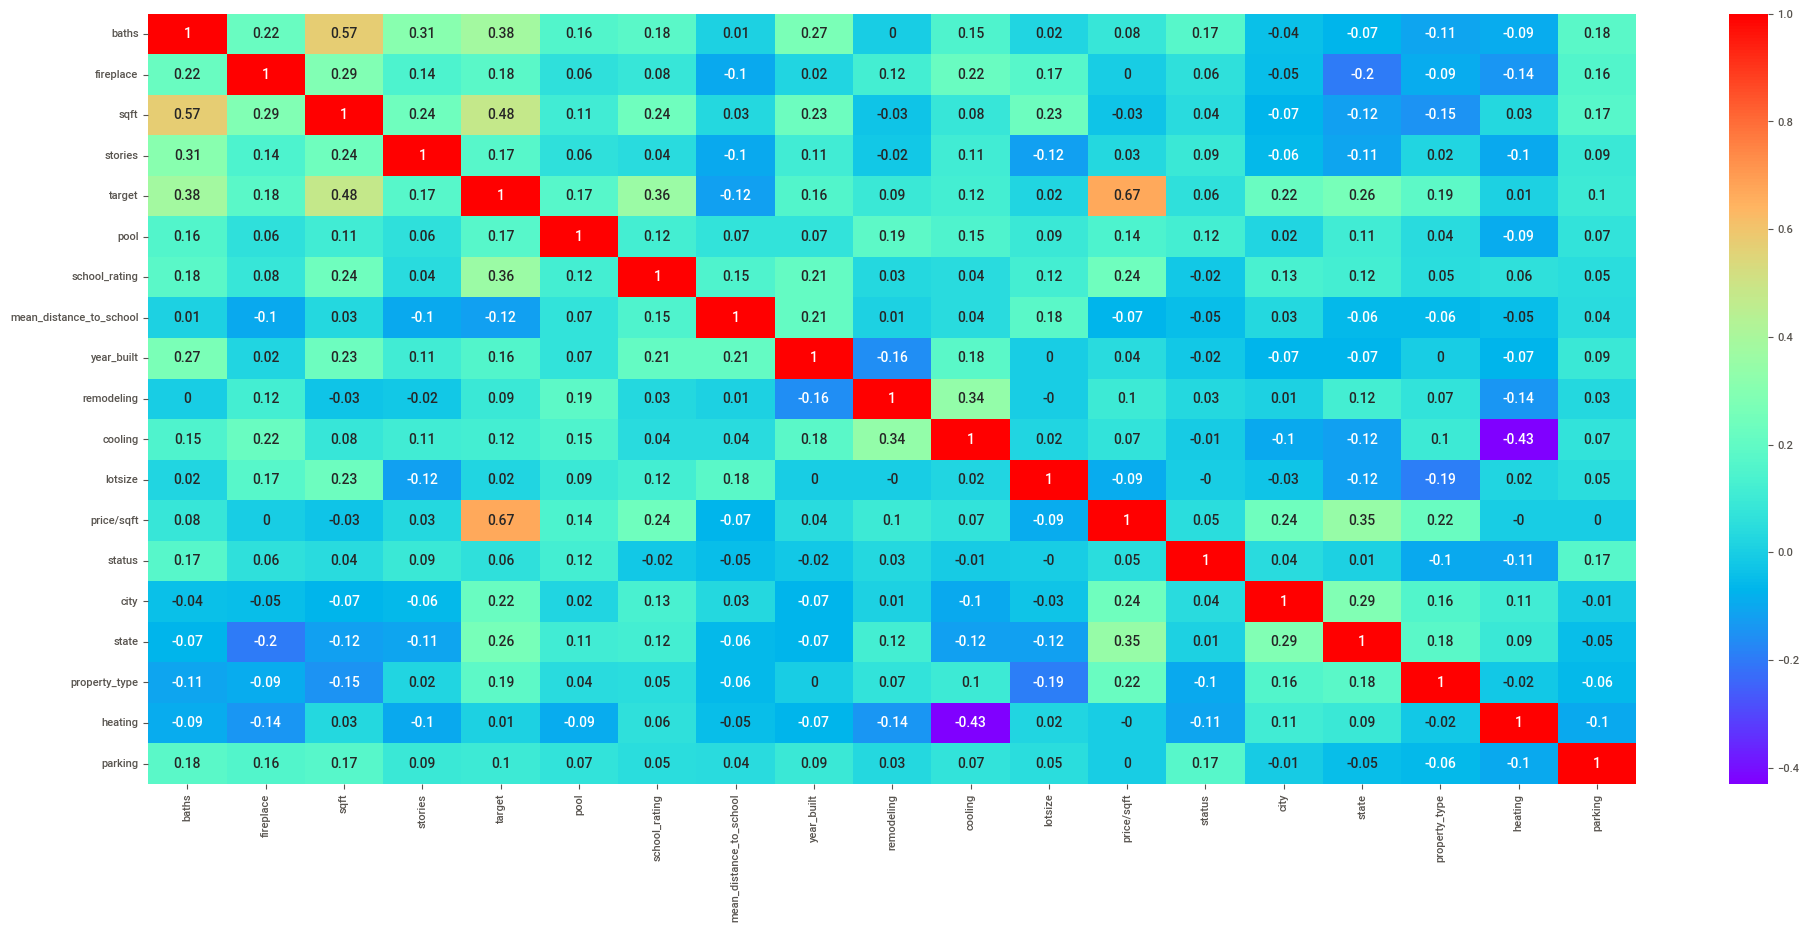

In [196]:
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(encoded_data.corr(method = 'spearman'), 2), cmap = 'rainbow', annot = True);


Корреляции признаков не наблюдается. Можно оставить полученный датасет без изменений.

In [197]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370982 entries, 0 to 370981
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   baths                    370982 non-null  float64
 1   fireplace                370982 non-null  int64  
 2   sqft                     370982 non-null  float64
 3   stories                  370982 non-null  float64
 4   target                   370982 non-null  float64
 5   pool                     370982 non-null  int64  
 6   school_rating            370982 non-null  float64
 7   mean_distance_to_school  370982 non-null  float64
 8   year_built               370982 non-null  float64
 9   remodeling               370982 non-null  int64  
 10  cooling                  370982 non-null  int64  
 11  lotsize                  370982 non-null  float64
 12  price/sqft               370982 non-null  float64
 13  status                   370982 non-null  float64
 14  city

In [198]:
encoded_data.shape

(370982, 19)

**В итоге всех манипуляций с данными мы получили набор данных размерностью 370982 строк на 19 столбцов в числовом формате, пригодный для построения предсказательной модели.**



---



Перейдём к построению моделей для обучения.

In [199]:
X = encoded_data.drop('target', axis=1)
y = encoded_data['target']

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
X_train_scaled = scaler.fit_transform(X_train)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [200]:
print('Train:', X_train_scaled.shape)
print('Test:', X_test_scaled.shape)

Train: (296785, 18)
Test: (74197, 18)


Создадим функцию, которая будет расчитывать метрики:

MAE - средняя абсолютная ошибка (целевая метрика);

R2 - коэффициент детерминации.

In [201]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.1f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.1f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('\n')
    print('Test R^2: {:.1f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.1f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))

**Линейная регрессия. Baseline**

In [202]:
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train)

#Делаем предсказание для каждой из выборок

y_train_predict = lr.predict(X_train_scaled)
y_test_predict = lr.predict(X_test_scaled)

#Выводим результирующие метрики
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.1
Train MAE: 499692.2


Test R^2: 0.1
Test MAE: 491415.7


**Дерево решений**

In [203]:
model_tree = tree.DecisionTreeRegressor(random_state=42)
model_tree.fit(X_train_scaled, y_train)

y_train_predict = model_tree.predict(X_train_scaled)
y_test_predict = model_tree.predict(X_test_scaled)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.9
Train MAE: 20010.7


Test R^2: 0.6
Test MAE: 105518.8


In [204]:
model_tree = tree.DecisionTreeRegressor(random_state=42, max_depth=13)
model_tree.fit(X_train_scaled, y_train)

y_train_predict = model_tree.predict(X_train_scaled)
y_test_predict = model_tree.predict(X_test_scaled)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.9
Train MAE: 106515.4


Test R^2: 0.6
Test MAE: 128523.5


**Случайный лес**

In [205]:
random_forest = ensemble.RandomForestRegressor(n_estimators=300,
                                               max_depth=16,
                                               min_samples_split = 20,
                                               criterion='squared_error',
                                               random_state=42)

random_forest.fit(X_train_scaled, y_train)

y_train_predict = random_forest.predict(X_train_scaled)
y_test_predict = random_forest.predict(X_test_scaled)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.8
Train MAE: 93365.4


Test R^2: 0.7
Test MAE: 103024.3


**Адаптивный бустинг**

In [206]:
dt = tree.DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    base_estimator=dt,
    random_state=42, #датчик генератора случайных чисел
    n_estimators=50, #количество моделей в ансамбле
    learning_rate=0.02
)

ada.fit(X_train_scaled, y_train)

y_train_predict  = ada.predict(X_train_scaled)
y_test_predict = ada.predict(X_test_scaled)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.6
Train MAE: 422833.1


Test R^2: 0.6
Test MAE: 417595.7


**Градиентный бустинг**

In [207]:
gb = GradientBoostingRegressor(
    max_depth=13, #максимальная глубина дерева
    n_estimators=500, #количество деревьев в ансамбле
    random_state=42, #генератор случайных чисел
    learning_rate=0.02
)

gb.fit(X_train_scaled, y_train)

y_train_predict  = gb.predict(X_train_scaled)
y_test_predict = gb.predict(X_test_scaled)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.9
Train MAE: 57980.8


Test R^2: 0.7
Test MAE: 95406.0


Покажем признаки, оказывающие наибольшее влияние на градиентный бустинг.

<AxesSubplot: >

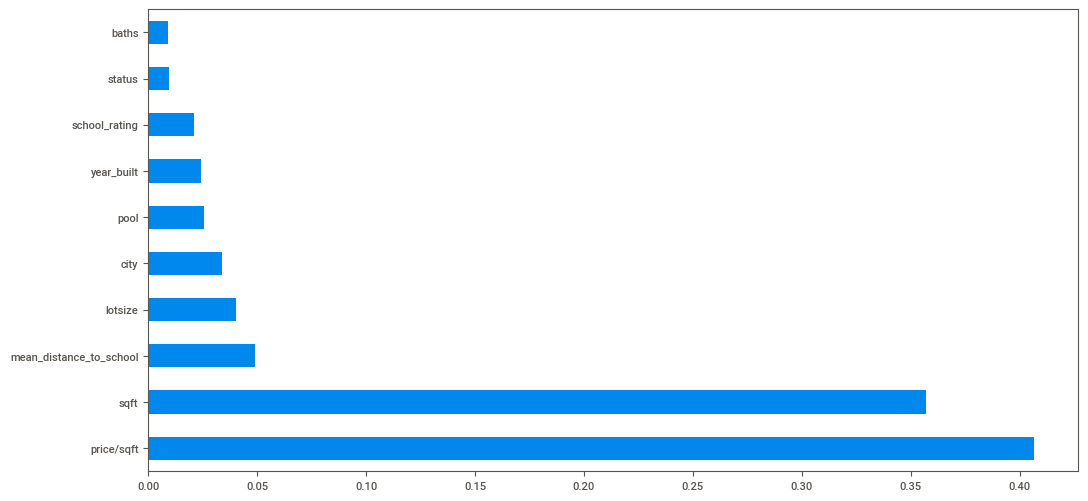

In [208]:
plt.rcParams['figure.figsize'] = (12,6)
feat_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

**CatBoost**

In [209]:
catmodel = CatBoostRegressor(random_state=42, verbose=False)
catmodel.fit(X_train_scaled, y_train)

y_train_predict  = catmodel.predict(X_train_scaled)
y_test_predict = catmodel.predict(X_test_scaled)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.9
Train MAE: 123074.2


Test R^2: 0.7
Test MAE: 136978.4


В итоге наилучший результат показывает моделирование при помощи градиентного бустинга. Метрика R2 показала наименьший коэффициент 0,778, а средняя абсолютная ошибка (МАЕ) составила 95533.5$ - наименьший результат среди всех испробованных моделей.

Полученный результат нельзя назвать оптимальным, для улучшения показателей можно провести более тщательную очистку данных, а также попробовать поискать дополнительные закономерности в данных.

**Подготовка модели к выпуску в эксплуатацию**

In [210]:
cols = data_new.drop(['target'],axis=1).columns

In [211]:
data_new

,status,baths,fireplace,city,sqft,state,stories,target,pool,property_type,school_rating,mean_distance_to_school,year_built,remodeling,heating,cooling,parking,lotsize,price/sqft
0,active,3.5,1,others,2900.0,NC,1.0,418000.0,0,single-family home,5.20,5.54,2019.0,0,other,0,other,6250.0,144.0
1,for sale,3.0,0,others,1947.0,WA,2.0,310000.0,0,single-family home,4.00,1.33,2019.0,0,other,0,other,5828.0,159.0
2,for sale,2.0,1,others,3000.0,CA,1.0,2895000.0,1,single-family home,6.67,1.96,1961.0,1,forced air,1,garage,8626.0,965.0
3,for sale,2.0,1,dallas,6457.0,TX,3.0,2395000.0,0,single-family home,9.25,0.75,2006.0,1,forced air,1,garage,8220.0,371.0
4,for sale,2.0,0,others,1656.0,FL,1.0,5000.0,0,land,4.67,4.08,1979.0,0,other,0,other,10019.0,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370977,for sale,6.0,0,miami,4017.0,FL,0.0,1249000.0,1,single-family home,7.50,16.60,1990.0,1,other,1,2 spaces,8500.0,311.0
370978,unknown,3.0,0,chicago,2000.0,IL,9.0,674999.0,0,condo,4.33,4.14,1924.0,0,other,0,other,6250.0,337.0
370979,for sale,3.0,0,others,1152.0,NY,2.0,528000.0,0,single-family home,4.50,0.60,1950.0,1,other,0,2 spaces,1600.0,458.0
370980,for sale,2.0,0,houston,1656.0,TX,1.0,34500.0,0,others,5.17,1.23,1979.0,0,other,0,other,6250.0,151.0


In [212]:
pipe = Pipeline([
  ('CatBoostEncoder', encoder),
  ('MinMaxScaler', scaler),
  ('GradientBoostingRegressor', gb)
  ])

In [213]:
X_p = data_new.drop(['target'], axis=1)
y_p = data_new['target']

In [214]:
pipe.fit(X_p, y_p)

Pipeline(steps=[('CatBoostEncoder',
                 CatBoostEncoder(cols=['status', 'city', 'state',
                                       'property_type', 'heating',
                                       'parking'])),
                ('MinMaxScaler', StandardScaler()),
                ('GradientBoostingRegressor',
                 GradientBoostingRegressor(learning_rate=0.02, max_depth=13,
                                           n_estimators=500,
                                           random_state=42))])

Пайплайн обучен. Сериализуем его в файл с помощью pickle.

In [215]:
with open('final_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Проверим работает ли десериалилизация из файла.

In [216]:
with open('final_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

Проверим идентичны ли файлы исходного и десериализованного пайплайнов.

In [217]:
print(all(pipe.predict(X_p) == loaded_pipe.predict(X_p)))

True


Сделаем пробное предсказание по заданным параметрам.

In [218]:
request = ['active', 3, 1, 'miami', 2540, 'FL', 3, 0, 'townhouse', 4.5, 1.5, 1999, 0, 'gas', 1, '2 spaces', 15489, 255]
req_f = pd.DataFrame([request], columns=cols)
pred = np.round(loaded_pipe.predict(req_f), 2)

In [219]:
print(pred)

[647521.89]


Зафиксируем зависимости в файле requirements.txt.

In [220]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


**Заключение**

В итоге получена рабочая модель по предсказанию цены недвижимости по задаваемым пользователем параметрам.

Файлы сервера и клиента для реализации веб-сервиса по обработке запросов прилагаются.

Работу над проектом можно считать оконченой.